# Trabajo Práctico Nro. 2
## Mineria de Datos 2024

### Integrantes:
 * Pace, Bruno. Legajo: P-5295/7.
 * Sancho Almenar, Mariano. Legajo: S-5778/9.

In [55]:
#Manejo de datos
import pandas as pd
import numpy as np

#Gráficos
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

#Modelado
#!pip install kneed
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import StandardScaler
# from sklearn import decomposition
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE, Isomap
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.sparse import csr_matrix
# from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import classification_report
# from scipy.stats import gaussian_kde
# import scipy.cluster.hierarchy as sch
# import matplotlib.pyplot as plt
# from kneed import KneeLocator
# import seaborn as sns



#Manejo de warnings
import warnings
warnings.filterwarnings('ignore')


### Lectura df

In [2]:
df_companies: pd.DataFrame = pd.read_csv('data/1000_Companies.csv')
df_pokemon: pd.DataFrame = pd.read_csv('data/PokemonDBCart.csv')


# Modelo de *df_companies*

Sobre el dataframe se utilizará un arbol de decisión por regresión.


- EDA.
- Visualizaciones.
- Tratamiento de outliers.
- Normalización.

In [3]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [4]:
df_companies.sample(10)

,RyD_Spend,Administration,MarketingSpend,State,Profit
124,1269.00,110644.5073,71227.57814,New York,50116.99489
115,123288.00,128664.8290,306663.57190,New York,154356.77370
38,20229.59,65947.9300,185265.10000,New York,81229.06000
287,39280.00,116258.1449,144569.90640,New York,82589.46419
767,146580.00,132104.6977,351605.54950,Florida,174254.92830
148,70585.00,120881.4099,204972.98940,New York,109333.05560
711,111501.00,126924.0712,283920.52320,New York,144287.24130
559,66766.00,120317.4026,197604.21850,California,106070.51680
253,17929.00,113104.9320,103373.09360,Florida,64349.48913
894,25990.00,114295.4172,118926.81520,Florida,71235.93187


Queremos saber si en la columna RyD_Spend hay decimales que no sean 0.

In [5]:
def check_decimals(x: float) -> bool:
    """
    Función auxiliar para determinar si un numero tiene o no parte decimal mayor a 0.
    """
    decimals = x - int(x)
    return decimals != 0

In [6]:
df_companies['decimals_ryd_spend'] = df_companies['RyD_Spend'].apply(check_decimals)

In [7]:
df_companies['decimals_ryd_spend'].value_counts()

decimals_ryd_spend
False    949
True      51
Name: count, dtype: int64

Comprobamos lo que queríamos, por ende ya esta columna no es necesaria. Decidimos dropearla.

In [8]:
df_companies = df_companies.drop('decimals_ryd_spend', axis=1)

Chequeamos que las columnas que quedaron son las originales.

In [9]:
df_companies.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit'], dtype='object')

Efectivamente sí hay decimales en esa columna.

In [10]:
df_companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


Vemos que hay demasiados decimales que no aportan información extra. Por simplicidad y prolijidad, redondeamos a dos decimales las columnas numericas de tipo float.

In [11]:
df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']] = df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].apply(lambda x: round(x,2))

In [12]:
df_companies.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

No hay valores faltantes, por ende, continuamos con el análisis.

### Visualizaciones

In [13]:
px.box(df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']], 
    title='Boxplot de las variables de compañias')

Observamos que hay potenciales outliers en las columnas Administration y Profit. Más adelante lo chequeamos.

In [14]:
px.histogram(
    df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']],
    title = 'Distribuciones de las variables'
)

- Administration tiene una distribución normal

In [15]:
df_companies[['Administration', 'Profit']].describe()

,Administration,Profit
count,1000.000000,1000.000000
mean,122963.897650,119546.164700
std,12613.927637,42888.633878
min,51283.140000,14681.400000
25%,116640.685000,85943.200000
50%,122421.610000,117641.465000
75%,129139.117500,155577.107500
max,321652.140000,476485.430000


In [16]:
administration_quantile_99: float = df_companies['Administration'].quantile(.99)
administration_quantile_01: float = df_companies['Administration'].quantile(.01)
profit_quantile_99: float = df_companies['Profit'].quantile(.99)

print(f'El cuantil 0.99 de Administration es: {round(administration_quantile_99,2)}')
print(f'El cuantil 0.01 de Administration: {round(administration_quantile_01,2)}')
print(f'El cuantil 0.99 de Profit es: {round(profit_quantile_99,2)}')

El cuantil 0.99 de Administration es: 152705.22
El cuantil 0.01 de Administration: 99809.38
El cuantil 0.99 de Profit es: 185033.03


In [17]:
df_companies_outliers: pd.DataFrame = df_companies.loc[
    (df_companies['Administration'] > administration_quantile_99) |
    (df_companies['Administration'] < administration_quantile_01) |
    (df_companies['Profit'] > profit_quantile_99)
]

print(df_companies_outliers.info())

df_companies_outliers

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       27 non-null     float64
 1   Administration  27 non-null     float64
 2   MarketingSpend  27 non-null     float64
 3   State           27 non-null     object 
 4   Profit          27 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.3+ KB
None


,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
4,142107.34,91391.77,366168.42,Florida,166187.94
11,100671.96,91790.61,249744.55,California,144259.40
14,119943.24,156547.42,256512.92,Florida,132602.65
19,86419.70,153514.11,0.00,New York,122776.86
21,78389.47,153773.43,299737.29,New York,111313.02
24,77044.01,99281.34,140574.81,New York,108552.04
28,66051.52,182645.56,118148.20,Florida,103282.38


Los potenciales outliers son sólo 27 casos. Previo a adoptar una estrategia se realiza su scatterplot.

In [18]:
fig2 = px.scatter(df_companies_outliers.drop(columns=['State']), title='Variables en función de sus índices.')
fig2.show()

La variable **MarketingSpend** posee outliers que son anteriores al índice 957. Se considera desde el index 958 en adelante que las ganancias obtenidas son producto de una buena estrategia adoptada por la empresa.

Al evaluar la variable **Administration**, se observa que si bien hay valores por encima del quantile 0.99 y por debajo del quantil 0.01, no están desfasados de los demás gastos/ganancias. 

La estrategia a adoptar, considerando la poca cantidad de datos outliers, es cambiarlos por la mediana.

In [19]:
# extracción de índices.
outliers_index: list[int] = df_companies_outliers.index[df_companies_outliers.index < 958].tolist() 

df_companies_filtered: pd.DataFrame = df_companies.copy()

# imputación.
df_companies_filtered['MarketingSpend'].loc[
    outliers_index
] = df_companies_filtered['MarketingSpend'].median()

In [20]:
# chequeo imputación.
df_companies_filtered.loc[outliers_index] 

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,224517.89,New York,192261.83
1,162597.70,151377.59,224517.89,California,191792.06
2,153441.51,101145.55,224517.89,Florida,191050.39
4,142107.34,91391.77,224517.89,Florida,166187.94
11,100671.96,91790.61,224517.89,California,144259.40
14,119943.24,156547.42,224517.89,Florida,132602.65
19,86419.70,153514.11,224517.89,New York,122776.86
21,78389.47,153773.43,224517.89,New York,111313.02
24,77044.01,99281.34,224517.89,New York,108552.04
28,66051.52,182645.56,224517.89,Florida,103282.38


In [21]:
corr_matrix = df_companies_filtered[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].corr()
px.imshow(corr_matrix,
          text_auto=True,
          aspect='auto',
          zmin=-1,
          zmax=1, title= 'Matriz de Correlación')

Vemos correlaciones fuertes:
 - Profit - MarketingSpend.
 - Profit - RyD_Spend.
 - MarketingSpend - RyDSpend.

 Hay una correlación que no es particularmente fuerte pero que es de destacar:
 - Profit - Administration.

 Analizando esto con el contexto que tenemos de las ganancias de las empresas con respecto a los gastos de Marketing y Desarrollo, no es descabellado pensar que mientras más se inviertan en estas áreas, más reditos económicos podemos conseguir. 
 Vemos una tendencia que a medida que se gasta más en personal de administración, más se gana.

In [22]:
df_companies_filtered['State'].value_counts()

State
California    344
New York      334
Florida       322
Name: count, dtype: int64


## Separación de conjuntos train-test

Se obtiene dos conjuntos train-test para la comparación de resultados

In [23]:
X: pd.DataFrame = df_companies_filtered.drop(columns=['Profit'], axis=1)
y: pd.DataFrame = pd.DataFrame(df_companies_filtered['Profit'], columns=['Profit'])

In [24]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=42
)

In [25]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=17
)


## Estandarización

Se utiliza el método de Z-score para la estandarización de los conjuntos


### Conjunto 1

In [26]:
X1_train_std = X1_train.drop(columns=['State'])
X1_test_std = X1_test.drop(columns=['State'])
# y1_train_std = y1_train.to_frame()

In [27]:
scaler1_x: StandardScaler = StandardScaler()
scaler1_y: StandardScaler = StandardScaler()

In [28]:
# Fit modelo de estandarización conjunto 1

X1_train_std: pd.DataFrame = pd.DataFrame(scaler1_x.fit_transform(X1_train_std), columns=X1_train_std.columns)
y1_train_std: pd.DataFrame = pd.DataFrame(scaler1_y.fit_transform(y1_train), columns=y1_train.columns)

In [29]:
# Estandarización conjuntos de test

X1_test_std: pd.DataFrame = pd.DataFrame(scaler1_x.transform(X1_test_std), columns=X1_test_std.columns)
y1_test_std: pd.DataFrame = pd.DataFrame(scaler1_y.transform(y1_test), columns=y1_test.columns)

In [30]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X1_train_std = pd.concat([X1_train_std, X1_train['State']], axis=1)
# X1_test_std = pd.concat([X1_test_std, X1_test['State']], axis=1)


### Conjunto 2

In [31]:
X2_train_std = X2_train.drop(columns=['State'])
X2_test_std = X2_test.drop(columns=['State'])

In [32]:
scaler2_x: StandardScaler = StandardScaler()
scaler2_y: StandardScaler = StandardScaler()

In [33]:
# Fit modelo de estandarización conjunto 1

X2_train_std: pd.DataFrame = pd.DataFrame(scaler2_x.fit_transform(X2_train_std), columns=X2_train_std.columns)
y2_train_std: pd.DataFrame = pd.DataFrame(scaler2_y.fit_transform(y2_train), columns=y2_train.columns)

In [34]:
# Estandarización conjuntos de test

X2_test_std: pd.DataFrame = pd.DataFrame(scaler2_x.transform(X2_test_std), columns=X2_test_std.columns)
y2_test_std: pd.DataFrame = pd.DataFrame(scaler2_y.transform(y2_test), columns=y2_test.columns)

In [35]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X2_train_std = pd.concat([X2_train_std, X2_train['State']], axis=1)
# X2_test_std = pd.concat([X2_test_std, X2_test['State']], axis=1)


## Árboles de decisión (Regresión)

Para el dataframe de las 1000 companías, se realizarán predicciones para la variable 'Profit' utilizando árboles de decisión por regresión.

En una primera instancia, se compara un modelo base de árbol con uno con parámetros específicos. 


### Modelo base usando los parámetros por defecto

In [48]:
tree_reg_base = DecisionTreeRegressor()

In [49]:
tree_reg_base.fit(X1_train_std, y1_train_std)

DecisionTreeRegressor()

In [50]:
y1_predict = tree_reg_base.predict(X1_test_std)


#### Obtención de métricas

In [57]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, y1_predict))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, y1_predict))
print("R2 Score:", r2_score(y1_test_std, y1_predict))

Mean Absolute Error (MAE): 0.043949756623686574
Mean Squared Error (MSE): 0.15941265442445476
R2 Score: 0.8720485747166467



#### Visualización

Profundidad del árbol: 11
Número de hojas: 200
Número total de nodos: 399


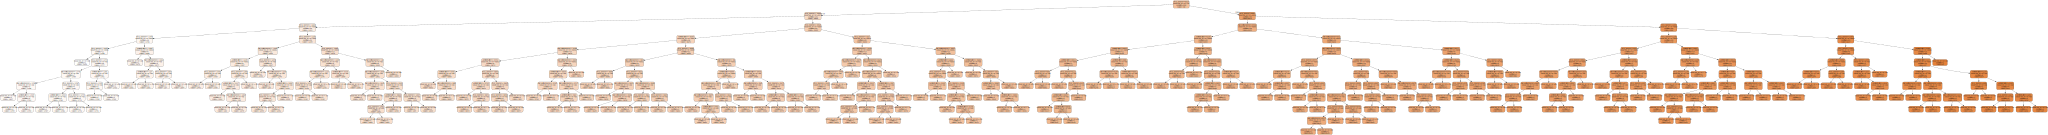

In [60]:
tree = export_graphviz(
        tree_reg_base, 
        out_file=None, 
        feature_names=X1_test_std.columns,
        class_names=y, 
        rounded=True, 
        filled=True)



print(f"Profundidad del árbol: {tree_reg_base.get_depth()}")
print(f"Número de hojas: {tree_reg_base.get_n_leaves()}")
print(f"Número total de nodos: {tree_reg_base.tree_.node_count}")
graphviz.Source(tree)

A partir de las métricas obtenidas y la visualización del árbol, donde se observa una gran cantidad de hojas y profundidad, podemos asumir que el modelo base presenta un **sobreajuste**.

Se realizará una poda del árbol, variando la profundidad, el número  mínimo  de  observaciones,  
el número mínimo de observaciones por separación y  un criterio de separación.

Se compararán los resultados con respecto al modelo base.

In [79]:
# Definir una lista de valores para los parámetros de poda
max_depths = [None, 3, 5, 7, 10]
min_samples_splits = [2, 5, 10]
min_samples_leaves = [1, 2, 5]
criterios = ['squared_error', 'friedman_mse', 'absolute_error'] 
results = []


for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leaves:
            for criterio in criterios:
            
                # Crear y entrenar el modelo
                tree_reg = DecisionTreeRegressor(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    criterion=criterio,
                    random_state=42
                )
                tree_reg.fit(X1_train_std, y1_train_std)
                
                y1_pred = tree_reg.predict(X1_test_std)
                
                # Calcular las métricas de evaluación
                mae = mean_absolute_error(y1_test, y1_pred)
                r2 = r2_score(y1_test, y1_pred)
                
                results.append({
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'criterio': criterio,
                    'MAE': mae,
                    'R²': r2
                    })

results_df = pd.DataFrame(results)

# Identificar el mejor modelo basado en la métrica deseada (por ejemplo, R² más alto)
best_model = results_df.loc[results_df['R²'].idxmax()]
print("Mejor modelo encontrado:")
print(best_model)

Mejor modelo encontrado:
max_depth                      3.0
min_samples_split                2
min_samples_leaf                 1
criterio             squared_error
MAE                  119115.636599
R²                       -7.419433
Name: 27, dtype: object



### Mejor modelo para el conjunto 1

Mean Absolute Error (MAE): 0.14912749812991183
Mean Squared Error (MSE): 0.1847629345001132
R2 Score: 0.8517013539848707


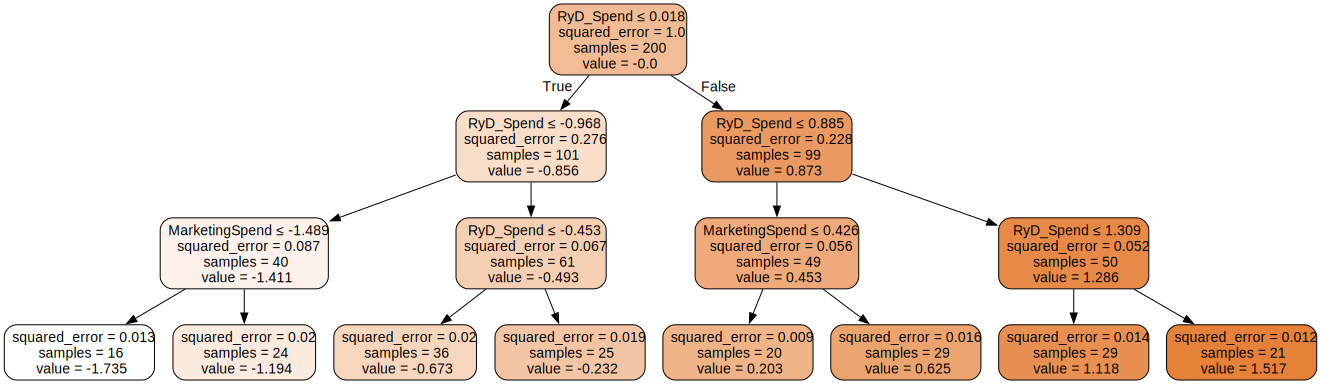

In [85]:
best_tree_reg = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg.fit(X1_train_std, y1_train_std)

dot_data = export_graphviz(best_tree_reg, 
                           out_file=None, 
                           feature_names=X1_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y1_pred = best_tree_reg.predict(X1_test_std)

# Obtención de la métricas del mejor modelo en el conjunto 1
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, best_y1_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, best_y1_pred))
print("R2 Score:", r2_score(y1_test_std, best_y1_pred))

graphviz.Source(dot_data)  


### Mejor modelo para el conjunto 2

Mean Absolute Error (MAE): 0.14455939772280757
Mean Squared Error (MSE): 0.13137453928439932
R2 Score: 0.8580189273290793


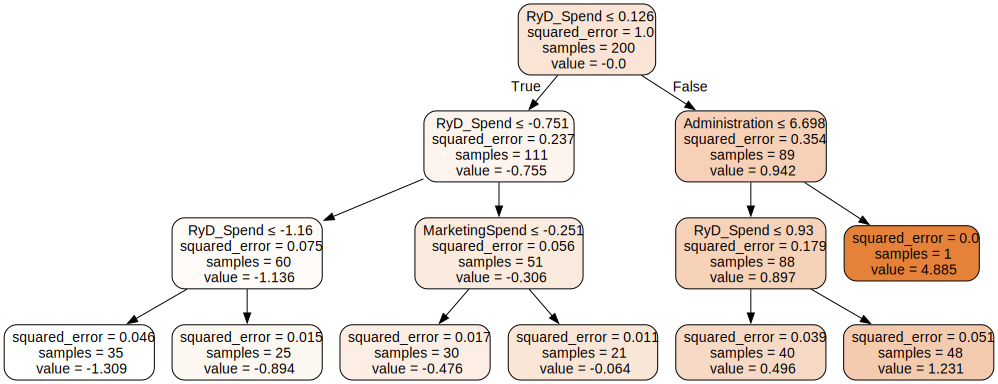

In [86]:
best_tree_reg2 = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg2.fit(X2_train_std, y2_train_std)


dot_data = export_graphviz(best_tree_reg2, 
                           out_file=None, 
                           feature_names=X2_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y2_pred = best_tree_reg.predict(X2_test_std)

# Obtención de métricas del mejor modelo en el conjunto 2
print("Mean Absolute Error (MAE):", mean_absolute_error(y2_test_std, best_y2_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y2_test_std, best_y2_pred))
print("R2 Score:", r2_score(y2_test_std, best_y2_pred))

graphviz.Source(dot_data)  


# Modelo *df_pokemon*